In [1]:
import warnings 

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 42
np.random.seed(42)


In [2]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [5]:
d = pd.read_csv("chimpanzees.csv", sep=";")
# actorを0というインデックスに変換する
d.actor = d.actor -1
d

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1
...,...,...,...,...,...,...,...,...
499,6,4.0,1,6,64,1,1,1
500,6,6.0,1,6,66,1,1,1
501,6,3.0,1,6,68,0,0,1
502,6,7.0,1,6,70,0,0,1


In [7]:
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]

,actor,prosoc_left,condition,treatment
0,0,0,0,0
1,0,0,0,0
2,0,1,0,1
3,0,0,0,0
4,0,1,0,1
...,...,...,...,...
499,6,1,1,3
500,6,1,1,3
501,6,0,1,2
502,6,0,1,2


In [9]:
d.groupby("treatment").first()[["prosoc_left", "condition"]]

,prosoc_left,condition
treatment,,
0,0,0
1,1,0
2,0,1
3,1,1


In [12]:
with pm.Model() as m11_1:
    a = pm.Normal("a", 0.0, 10.0)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_1 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1 = prior_11_1["prior"]

# 事前予測のプロットを作りなおす必要がある
with pm.Model() as m11_1bis:
    a = pm.Normal("a", 0.0, 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_1bis = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1bis = prior_11_1bis["prior"]

Sampling: [a, pulled_left]
Sampling: [a, pulled_left]


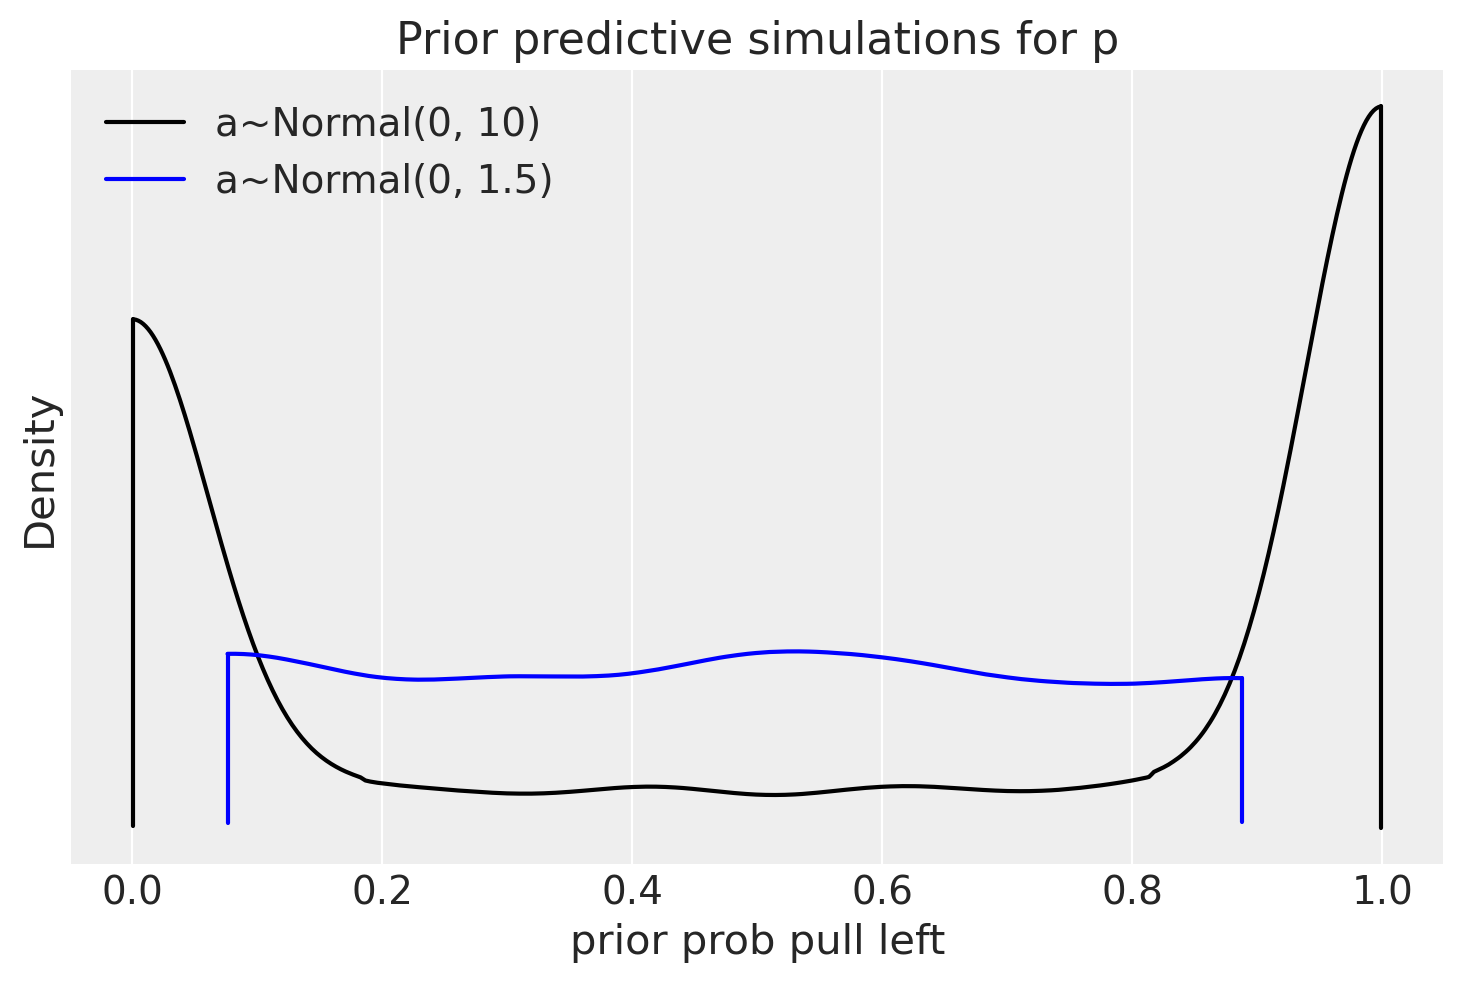

In [14]:
ax = az.plot_density(
    [idata_11_1, idata_11_1bis],
    data_labels=["a~Normal(0, 10)", "a~Normal(0, 1.5)"],
    group="prior",
    colors=["k", "b"],
    var_names=["p"],
    point_estimate=None,
)[0]
ax[0].set_xlabel("prior prob pull left")
ax[0].set_ylabel("Density")
ax[0].set_title("Prior predictive simulations for p");

In [16]:
with pm.Model () as m11_2:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 10.0, shape=4)

    p = pm.math.invlogit(a + b[d.treatment.values])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_2 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
prior_2 = prior_11_2["prior"]

with pm.Model() as m11_3:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 0.5, shape=4)

    p = pm.math.invlogit(a + b[d.treatment.values])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_3 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
prior_3 = prior_11_3["prior"]

Sampling: [a, b, pulled_left]
Sampling: [a, b, pulled_left]
